In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import json
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 800)
pd.set_option('display.width', 1000)

In [2]:
def filter_json(img, ann):
    img_name = img.split(os.sep)[-1]
    img_size = ann.get('size')
    objects = [ format_bbox(obj, img_size) for obj in ann.get('objects') ]
    obj = {
        'name': img_name,
        'width': img_size.get('width'),
        'height': img_size.get('height'),
        'objects': objects,
        'object_count': len(objects),
    }
    return obj


def format_bbox(obj, img_size):
    """ formats (defect detection) points """
    
    bbox = format_bndbox_to_yolo(img_size['width'], img_size['height'],
                                obj['points']['exterior'][0][0],
                                obj['points']['exterior'][0][1],
                                obj['points']['exterior'][1][0],
                                obj['points']['exterior'][1][1],
    )
    
    obj_simp = {
        'classTitle': obj.get('classTitle'),
        'classId': obj.get('classId'),
        'bbox': bbox,
    }
    return obj_simp


def format_bndbox_to_yolo(img_width: float, img_height: float, xmin: float, ymin: float, xmax: float, ymax: float) -> \
        dict[str, float]:
    """ Converts bounding boxes to format: x_center y_center width height """
    width = xmax - xmin
    x_center = xmin + width / 2
    x_center, width = x_center / img_width, width / img_width

    height = ymax - ymin
    y_center = ymin + height / 2
    y_center, height = y_center / img_height, height / img_height

    return { 'x_center': x_center, 'y_center': y_center, 'width': width, 'height': height }


In [ ]:
""" 
COUNT    (ID, TITLE)
10324    (6512001, 'alligator crack')
24770    (6511999, 'longitudinal crack')
6458     (6512002, 'pothole')
10612    (6512000, 'transverse crack')
5850     (6512003, 'other corruption')
"""
json_label_map = {
    6511999: 0, # longitudinal crack
    6512000: 1, # transverse crack
    6512001: 2, # alligator crack
    6512002: 3, # pothole
    6512003: 4, # other corruption
}

def get_string_label(obj):
    label_id = json_label_map[ obj['classId'] ]
    key_order = [ 'x_center', 'y_center', 'width', 'height' ]
    int_str = ' '.join([ str(obj['bbox'].get(key)) for key in key_order ])
    return f'{label_id} {int_str}'

In [4]:
def get_img_json(img):
    """ gets image annotations from json as python dict """
    json_fp = get_img_json_filepath(img)
    with open(json_fp, 'r') as f:
        return json.load(f)

def get_img_json_filepath(img):
    return str(img).replace(f'{os.sep}img{os.sep}', f'{os.sep}ann{os.sep}') + '.json'

In [5]:
def get_annotations(dataset_path, limit=None):
    
    if not os.path.exists(dataset_path):
        print('No such dataset: "{}"'.format(dataset_path))
    # dataset_pp_path = f'{SCRATCH}/datasets/RDD2022_allas_pp_{int(args.fraction*100)}'
    
    print('Pre-processing dataset: "{}"'.format(dataset_path))
    # print('Saving preprocessed dataset to: "{}"'.format(dataset_pp_path))
    
    train_img_dir = f'{dataset_path}/train/img'
    train_images = [ img for img in Path(train_img_dir).glob('*.jpg') ]
    train_images = [ img for img in train_images if 'China_Drone' not in str(img) ]
    
    print('Found {:_} images in /train/img'.format(len(train_images)))

    anns = []

    try:
        for idx, img in enumerate(train_images):
            perc = (idx+1)/len(train_images)*100
            print('\rextracting {:_}/{:_} ({:.1f}%): "{}"'.format(idx+1, len(train_images), perc, img.name), end='')
            fn = str(img)
            img_json = get_img_json(fn)
            img_json = filter_json(fn, img_json)
            anns.append(img_json)
            if limit and idx >= limit:
                break
        print()
    except KeyboardInterrupt:
        print('\n... interrupted')
    
    print('done.')
    return anns

In [11]:
# GLOBAL VARIABLES
DATASET_PATH = '../../datasets/RDD2022_allas'

In [ ]:
# START: RUN ALL ABOVE
...

In [10]:
# [LOAD]
df = pd.read_pickle('data/data.pkl')
df

,width,height,objects,object_count,subset,labels
name,,,,,,
China_MotorBike_000000.jpg,512,512,"[{'classTitle': 'alligator crack', 'classId': ...",3,China_MotorBike,[2 0.6640625 0.1767578125 0.66796875 0.3496093...
China_MotorBike_000001.jpg,512,512,"[{'classTitle': 'pothole', 'classId': 6512002,...",1,China_MotorBike,[3 0.4306640625 0.49609375 0.068359375 0.15625]
China_MotorBike_000002.jpg,512,512,"[{'classTitle': 'longitudinal crack', 'classId...",2,China_MotorBike,[0 0.435546875 0.681640625 0.08203125 0.632812...
China_MotorBike_000003.jpg,512,512,"[{'classTitle': 'longitudinal crack', 'classId...",5,China_MotorBike,"[0 0.37890625 0.3095703125 0.125 0.611328125, ..."
China_MotorBike_000004.jpg,512,512,"[{'classTitle': 'pothole', 'classId': 6512002,...",1,China_MotorBike,[3 0.24609375 0.197265625 0.04296875 0.03125]
...,...,...,...,...,...,...
United_States_004800.jpg,640,640,"[{'classTitle': 'longitudinal crack', 'classId...",5,United_States,"[0 0.828125 0.8984375 0.203125 0.2, 2 0.46875 ..."
United_States_004801.jpg,640,640,"[{'classTitle': 'transverse crack', 'classId':...",1,United_States,[1 0.36171875 0.78125 0.0859375 0.01875]
United_States_004802.jpg,640,640,"[{'classTitle': 'longitudinal crack', 'classId...",2,United_States,"[0 0.784375 0.859375 0.3 0.26875, 0 0.80859375..."


In [ ]:
# [GENERATE] Generate dataframe from dataset
data = get_annotations(DATASET_PATH, limit=None)
df = pd.DataFrame(data).set_index('name')
df

In [9]:
# [SAVE]
df.to_pickle('data/data.pkl')

In [7]:
# [ANALYSE] Find classes
classes = {}

for idx, (name, data) in enumerate(df.iterrows()):
    print('\r({:_}/{:_})'.format(idx+1, len(df)), end='')
    objects = data['objects']
    for obj in objects:
        tpl = (obj['classId'], obj['classTitle'])
        classes[tpl] = classes.get(tpl, 0) + 1
    # break
print('  done.')

print('\nCOUNT    (ID, TITLE)')
for k, v in classes.items():
    print('{:<8} {}'.format(v, k))

(35_984/35_984)  done.

COUNT    (ID, TITLE)
10324    (6512001, 'alligator crack')
24770    (6511999, 'longitudinal crack')
6458     (6512002, 'pothole')
10612    (6512000, 'transverse crack')
5850     (6512003, 'other corruption')


In [8]:
# [MODIFY] Apply more processing to df
def get_subset_from_name(name):
    last = name.split('_')[-1]
    return name.replace(f'_{last}', '')

df['subset'] = df.index.map(lambda name: get_subset_from_name(name))
df['labels'] = df['objects'].apply(lambda objects: [get_string_label(obj) for obj in objects] if isinstance(objects, list) else [])
df

,width,height,objects,object_count,subset,labels
name,,,,,,
China_MotorBike_000000.jpg,512,512,"[{'classTitle': 'alligator crack', 'classId': ...",3,China_MotorBike,[2 0.6640625 0.1767578125 0.66796875 0.3496093...
China_MotorBike_000001.jpg,512,512,"[{'classTitle': 'pothole', 'classId': 6512002,...",1,China_MotorBike,[3 0.4306640625 0.49609375 0.068359375 0.15625]
China_MotorBike_000002.jpg,512,512,"[{'classTitle': 'longitudinal crack', 'classId...",2,China_MotorBike,[0 0.435546875 0.681640625 0.08203125 0.632812...
China_MotorBike_000003.jpg,512,512,"[{'classTitle': 'longitudinal crack', 'classId...",5,China_MotorBike,"[0 0.37890625 0.3095703125 0.125 0.611328125, ..."
China_MotorBike_000004.jpg,512,512,"[{'classTitle': 'pothole', 'classId': 6512002,...",1,China_MotorBike,[3 0.24609375 0.197265625 0.04296875 0.03125]
...,...,...,...,...,...,...
United_States_004800.jpg,640,640,"[{'classTitle': 'longitudinal crack', 'classId...",5,United_States,"[0 0.828125 0.8984375 0.203125 0.2, 2 0.46875 ..."
United_States_004801.jpg,640,640,"[{'classTitle': 'transverse crack', 'classId':...",1,United_States,[1 0.36171875 0.78125 0.0859375 0.01875]
United_States_004802.jpg,640,640,"[{'classTitle': 'longitudinal crack', 'classId...",2,United_States,"[0 0.784375 0.859375 0.3 0.26875, 0 0.80859375..."


In [30]:
# [ANALYSE] Find distribution of countries
df.groupby('subset').size()

subset
China_MotorBike     1977
Czech               2829
India               7706
Japan              10506
Norway              8161
United_States       4805
dtype: int64

In [ ]:
# [VISUALIZE]
df.groupby('object_count').size()

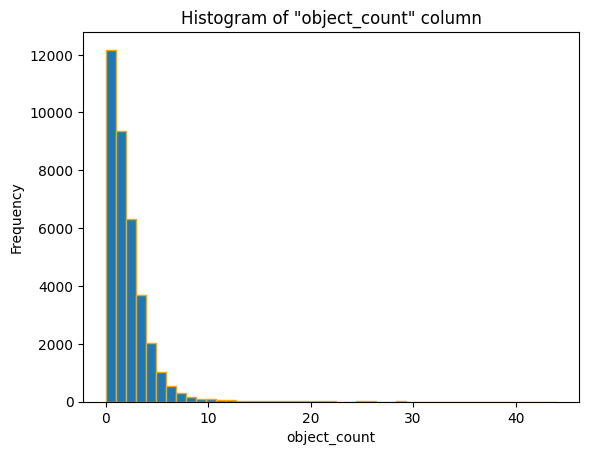

In [107]:
# [VISUALIZE] histogram of specific column
attr = 'object_count'
bins = df[attr].max() - df[attr].min() + 1
plt.hist(df[attr], bins=bins, edgecolor='orange')

plt.xlabel(attr)
plt.ylabel('Frequency')
plt.title(f'Histogram of "{attr}" column')
plt.show()

In [ ]:
# TEST [VISUALIZE] 2d histogram of width-height
print(df['width'].max())
bin_width = 10
bin_height = 10
x_bins = np.arange(df['width'].min(), df['width'].max() + bin_width, bin_width)
y_bins = np.arange(df['height'].min(), df['height'].max() + bin_height, bin_height)

# Plot 2D histogram
plt.figure(figsize=(8, 6))
hist = plt.hist2d(df['width'], df['height'], bins=[x_bins, y_bins], cmap='plasma')

# Add colorbar
plt.colorbar(label='Count')

# Labels and title
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('2D Histogram with Color Intensity')

plt.xscale('log')
plt.yscale('log')

# Show plot
plt.show()

In [105]:
df.groupby('width').size()

width
512      1977
540       124
600     13016
640      4805
720      7706
1024      147
1080       48
3643     2896
3650      923
4040     4342
dtype: int64

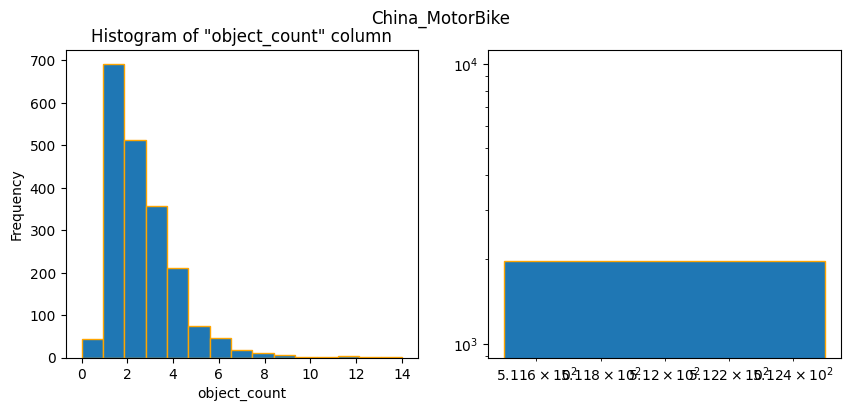

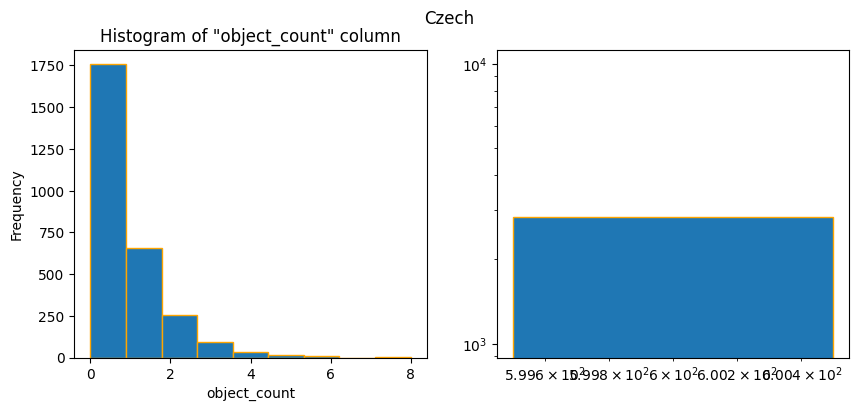

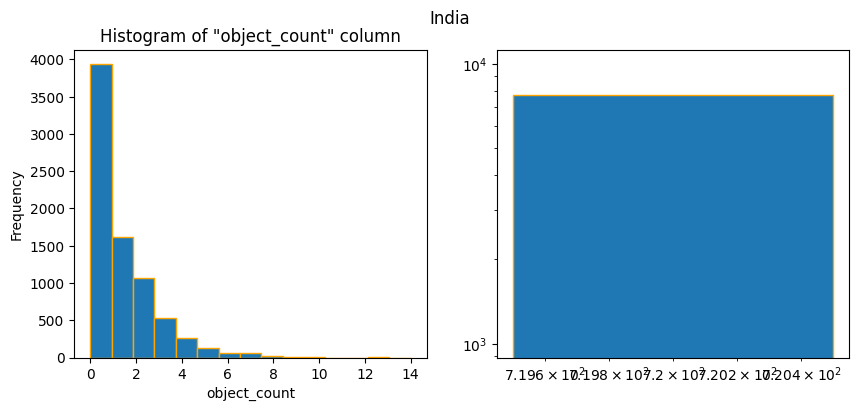

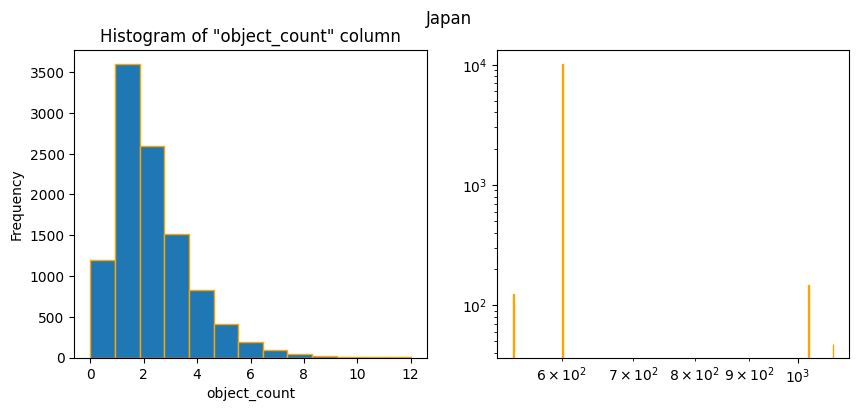

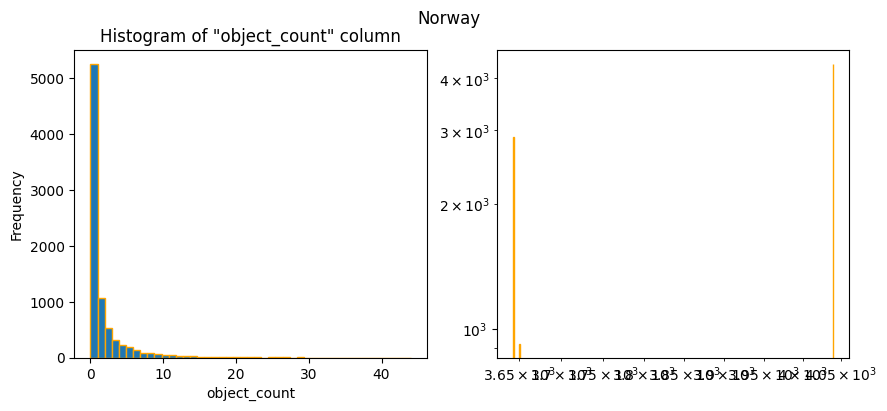

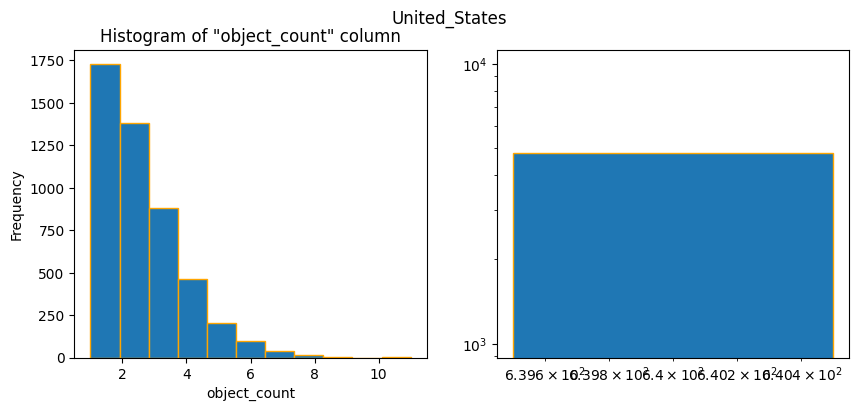

In [106]:
# [VISUALIZE] show object count and width distribution per country
subsets = df.groupby('subset')
# fig, ax = plt.subplots(nrows=len(subsets), figsize=(7,len(subsets)*3))
for idx, (name, dataframe) in enumerate(subsets):
    
    fig_row, ax_sub = plt.subplots(ncols=2, figsize=(10,4))
    
    # hist of object count
    attr = 'object_count'
    bins = dataframe[attr].max() - dataframe[attr].min() + 1
    ax_sub[0].hist(dataframe[attr], bins=bins, edgecolor='orange')

    ax_sub[0].set_xlabel(attr)
    ax_sub[0].set_ylabel('Frequency')
    ax_sub[0].set_title(f'Histogram of "{attr}" column')
    
    # hist of height
    attr = 'width'
    bins = dataframe[attr].max() - dataframe[attr].min() + 1
    ax_sub[1].hist(dataframe[attr], bins=bins, edgecolor='orange')
    ax_sub[1].set_xscale('log')
    ax_sub[1].set_yscale('log')
    
    fig_row.suptitle(str(name))
    plt.show()
    # break
# fig.tight_layout()
# plt.show()